# Walmart Project

In [1]:
#Import de bibliotheques
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


In [2]:
#chargement de données
dataset=pd.read_csv("Walmart_Store_sales.csv")

In [3]:
#faire une copie pour eviter de la charger à chaque fois
df=dataset.copy()

In [4]:
#Afficher les premieres lignes
display(df.head())

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [5]:
#la taille de dataset
df.shape

(150, 8)

In [6]:
#Realiser les statistiques de base
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


In [7]:
#le nombre de valeurs non-null dans chaque colonne et le type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [8]:
print(f"le pourcentage de valeur manquantes \n{(df.isnull().sum()/df.shape[0])*100}")

le pourcentage de valeur manquantes 
Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64


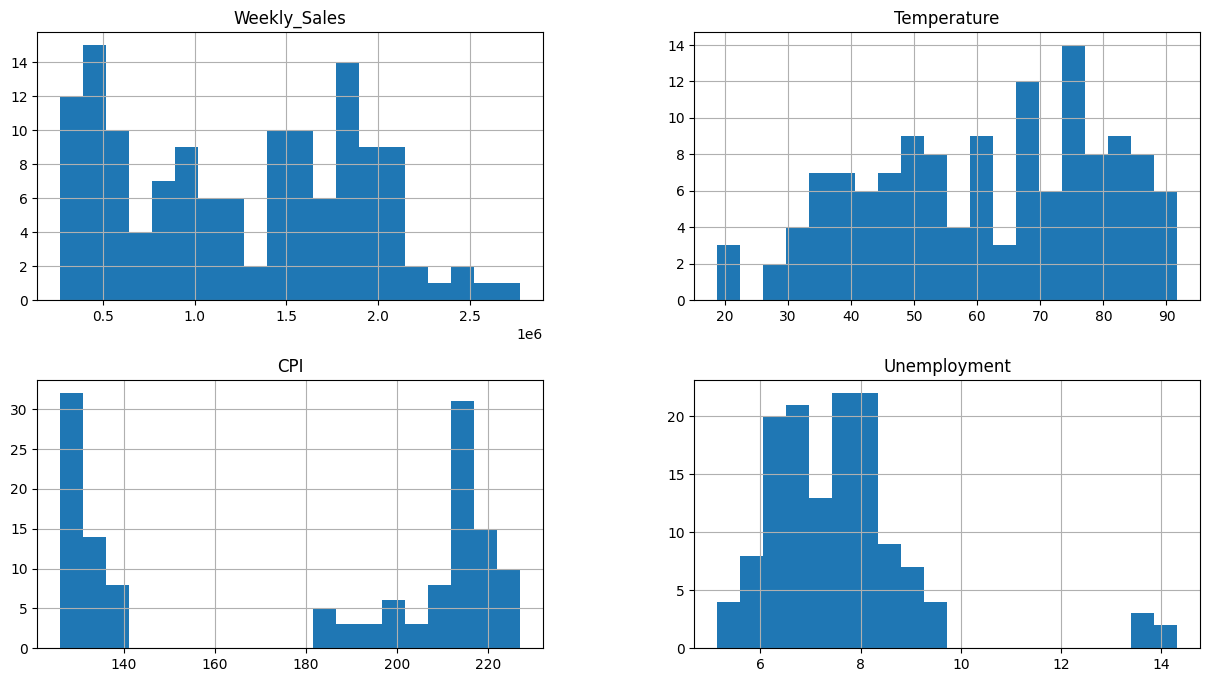

In [9]:
# #La distribution des variables
# # Variables quantitatives
cols=["Weekly_Sales","Temperature","CPI","Unemployment"]
#df3=df_net[cols]
df[cols].hist(bins=20, figsize=(15, 8))
plt.show()

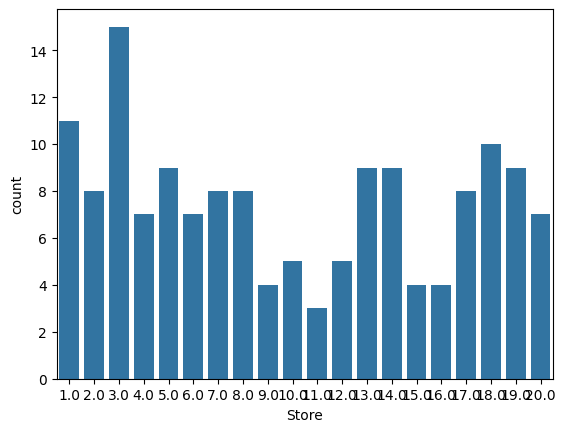

In [10]:
# #Variables qualitatives
import seaborn as sns
# Store
sns.countplot(x='Store', data=df)

plt.show()

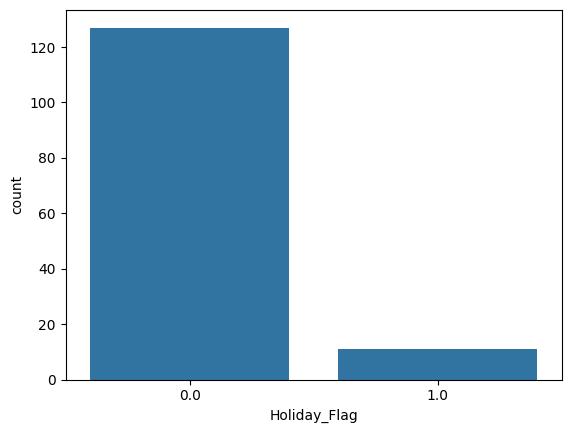

In [11]:
#Holiday Flag
sns.countplot(x='Holiday_Flag', data=df)
plt.show()

In [12]:
#supprimer les lignes dont les valeurs de weekly sales sont manquantes
df = df.dropna(subset=["Weekly_Sales"])

display(df.count())

Store           136
Date            118
Weekly_Sales    136
Holiday_Flag    125
Temperature     121
Fuel_Price      124
CPI             125
Unemployment    122
dtype: int64

In [13]:
# Transformer la date en datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [14]:
#jour de semaine, jour, mois et année
df.loc[:, "Weekday"] = df['Date'].dt.day_of_week
#df["Weekday"] = df['Date'].dt.day_of_week
df.loc[:,"Day"] = df['Date'].dt.day
df.loc[:,"Month"] = df['Date'].dt.month
df.loc[:,"Year"] = df['Date'].dt.year


In [15]:
df=df.drop(columns=["Date"],axis=1)
display(df.head())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekday,Day,Month,Year
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,4.0,18.0,2.0,2011.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,4.0,25.0,3.0,2011.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,4.0,28.0,5.0,2010.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,4.0,28.0,5.0,2010.0


In [16]:
# #Supprimer les valeurs aberantes qui se situent en dehors de l'intervalle [X_bar - 3*Sigma,X_bar + 3*Sigma]
cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for col in cols :
    Min_interval = df[col].mean() - (df[col].std()*3)
    Max_interval = df[col].mean() + (df[col].std()*3)
    mask = df[(df[col] < Min_interval) & (df[col] > Max_interval)].index.to_list()
    #df=df[mask]
    df = df.drop(mask)

print(df.count())

Store           136
Weekly_Sales    136
Holiday_Flag    125
Temperature     121
Fuel_Price      124
CPI             125
Unemployment    122
Weekday         118
Day             118
Month           118
Year            118
dtype: int64


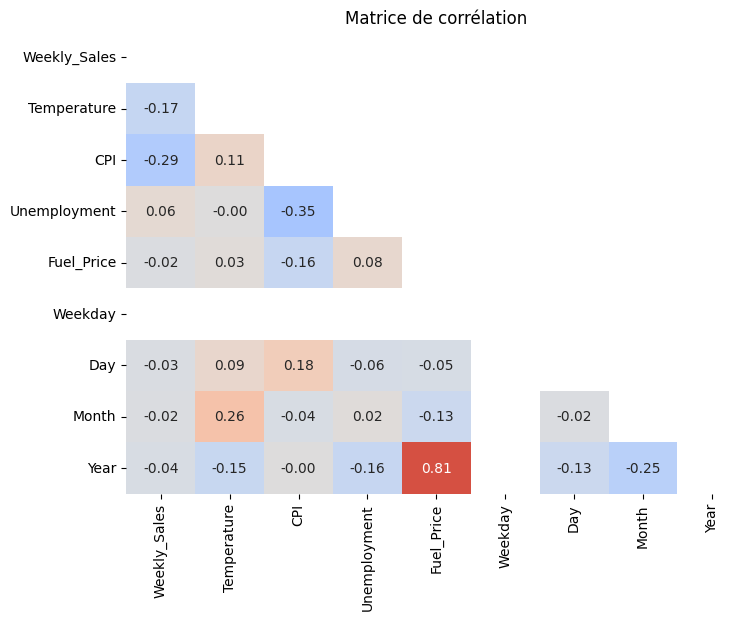

In [17]:
# Calculer la matrice de corrélation
cols = ["Weekly_Sales", "Temperature", "CPI", "Unemployment", "Fuel_Price","Weekday","Day","Month","Year"]
corr_matrix = df[cols].corr().round(2)

# Créer un masque pour la moitié supérieure
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Configurer la taille de la figure
plt.figure(figsize=(8, 6))

# Générer une carte thermique (heatmap) de la matrice de corrélation avec le masque
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1,cbar=False)

plt.title('Matrice de corrélation')
plt.show()

Baseline model : simple linear regression

In [18]:
# Je sépare la variable à expliquer de la variable expliquative ici
print("Separation of feature and target")
target_variable = "Weekly_Sales"
Y = df.loc[:,target_variable]
X = df.drop(target_variable, axis = 1)
print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separation of feature and target
...Done.

Y : 
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
3   11.0           0.0        84.57         NaN  214.556497         7.346   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
5    4.0           0.0          NaN       2.756  126.160226         7.896   

   Weekday   Day  Month    Year  
0      4.0  18.0    2.0  2011.0  
1      4.0  25.0    3.0  2011.0  
3      NaN   NaN    NaN     NaN  
4      4.0  28.0    5.0  2010.0  
5      4.0  28.0    5.0  2010.0  


In [19]:
# Je divise le jeu de données en jeu d'entrainement 80% et teste 20%
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



Preprocessing

In [20]:
numeric_features = ['Temperature', 'Fuel_Price','CPI', 'Unemployment']
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

# Stores are numbers but nominal data, it is not a ranking
categorical_features = ['Store','Holiday_Flag','Year','Month','Day','Weekday']
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

In [21]:
# Appliquer le pipeline sur les données d'entraînement
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

...Done!
  (0, 0)	-1.3443339137348629
  (0, 1)	0.8842634017817701
  (0, 2)	0.37112282387687245
  (0, 3)	0.6353006433739283
  (0, 9)	1.0
  (0, 24)	1.0
  (0, 29)	1.0
  (0, 48)	1.0
  (1, 0)	0.4623461935884155
  (1, 1)	0.5198897162492313
  (1, 2)	1.1693072473242205
  (1, 3)	-0.7884279551276236
  (1, 25)	1.0
  (1, 34)	1.0
  (1, 54)	1.0
  (2, 0)	1.0707180664625808
  (2, 1)	-1.3525276620075715
  (2, 2)	0.9363734004214289
  (2, 3)	-0.15770060465701044
  (2, 5)	1.0
  (2, 30)	1.0
  (2, 39)	1.0
  (3, 0)	1.1536778673090577
  (3, 1)	1.3160356881064548
  (3, 2)	-1.1144620347091307
  (3, 3)	0.13555784409564492
  (3, 17)	1.0
  (3, 30)	1.0
  (3, 47)	1.0
  (4, 0)	0.3505809063369118
  (4, 1)	-1.4325635004482453
  (4, 2)	0.9417710244488358
  (4, 3)	-0.6665641850628058
  (4, 5)	1.0
  (4, 30)	1.0
  (4, 47)	1.0



In [22]:
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = preprocessor.transform(X_test)
#X_test = preprocessor.transform(X_test)
print("...Done!")
print(X_test[0:5,:]) # X_test is now a numpy array
print()

Preprocessing X_test...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
80     9.0           0.0        49.96       2.771  215.437285         6.560   
48     1.0           NaN        91.65       3.684  215.544618         7.962   
64     4.0           0.0        36.44       3.149  129.898065         5.143   
45     2.0           0.0        54.63       3.555  220.275944         7.057   
142    3.0           0.0        75.54       3.285         NaN         7.197   

     Weekday   Day  Month    Year  
80       4.0  19.0   11.0  2010.0  
48       4.0   5.0    8.0  2011.0  
64       4.0  16.0   12.0  2011.0  
45       4.0  24.0    2.0  2012.0  
142      4.0   7.0   10.0  2011.0  

...Done!
  (0, 0)	-0.5752274267206483
  (0, 1)	-1.21351804787377
  (0, 2)	0.9609308180697107
  (0, 3)	-0.6536430784654969
  (0, 11)	1.0
  (0, 35)	1.0
  (0, 54)	1.0
  (1, 0)	1.8265740297304833
  (1, 1)	0.7094482809771422
  (1, 2)	0.963730562426564
  (1, 3)	0.2343663063103634
  (1, 24)

Entrainement du modèle

In [23]:
#J'applique une regression lineaire simple
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


Evaluer les performances

In [24]:
regressor.score(X_train,Y_train)

0.9952927682064928

In [25]:
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[ 508249.95181632 1555208.67498117  404015.77855973  578343.02667536
  422119.90232203  275144.19994689 1607668.78943967 1799739.62208528
 1818767.61383934  273279.38142784 2077823.35858462 2018982.78512079
 2056480.74585965 1974530.65914736 1077899.53217498 1655722.0885996
 1397960.27044104  926262.1279504   288802.99836606 1085432.30542887
 2001295.22624017 2093292.31305799 1741814.44821131 1467600.17524108
  932432.01309585  303809.29306736 2113122.63560003  483072.10128048
 2044901.1692836   973277.39669035 1409584.29612682 1508578.85056664
 2133381.11034866  879915.93769764  721829.07202205 1260835.31104017
 1776770.94101028 2344438.90820442  440193.01960106 1980974.3114695
  998028.19580874 1371688.05969702 2592869.44083894  261844.29374561
  591849.51040346  957291.66620071  799089.74699428  928866.75279742
  433567.12821929  863346.59821308  468899.2266043  1639921.96212622
 2418101.85829204  511027.48628668 1817059.02363263 1439505.70842

In [26]:
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[ 538902.4319022  1521261.64587078 2577947.27388643 1997495.58914391
  132595.88971193 1066861.19025361 1560428.86328756 1955285.33470937
  342817.32775704  986342.5192603  1576878.48675312 1795211.77503792
 1052217.40603462  371846.35663547 1980007.35587365  512896.69773048
  596498.98870825 1476535.77629777 2023781.31770776  344557.61950441
  840278.66028165  418973.38439316 1614899.8762802  1096924.19652176
  646377.34611636  966059.50851807 2310561.48560804 1936144.30842508]



In [27]:
# Calculer le R^2
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9952927682064928
R2 score on test set :  0.951892932950295


Text(0.5, 0, 'Coefficient Value')

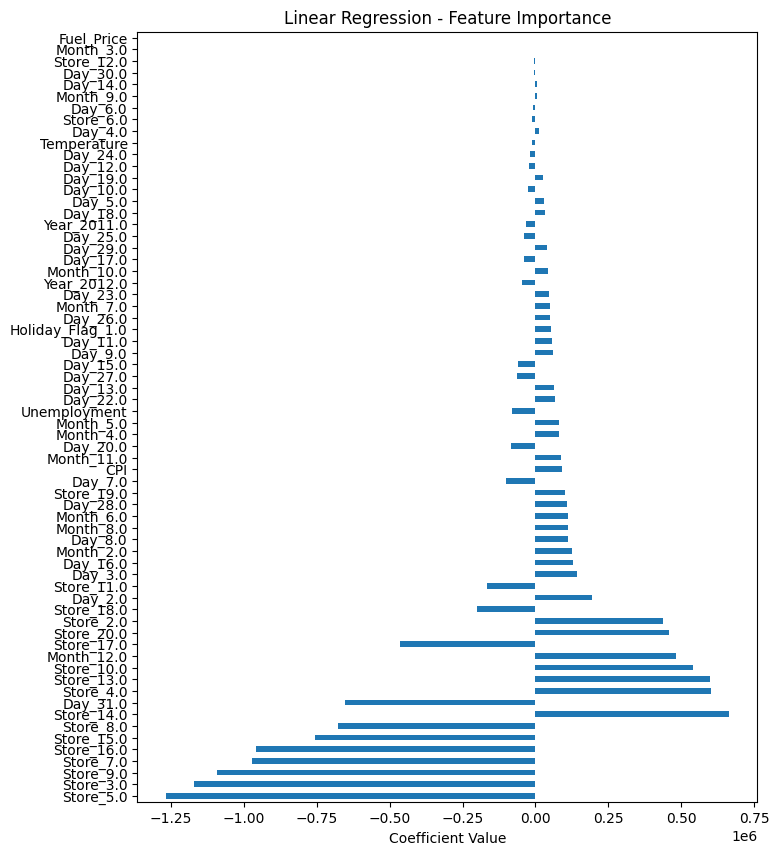

In [28]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   regressor.coef_,
   columns=['Coefficients'], index=col_names
)
# Trier les coefficients par leur valeur absolue en ordre décroissant
coefs['Absolute Coefficient'] = coefs['Coefficients'].abs()
coefs_sorted = coefs.sort_values(by='Absolute Coefficient', ascending=False)

# Affichage du graphique en barres horizontales
coefs_sorted['Coefficients'].plot(kind='barh', figsize=(8, 10))
plt.title('Linear Regression - Feature Importance')
plt.xlabel('Coefficient Value')

# Entrainement du modele de regression lineaire avec régularisation

In [29]:
target_variable = "Weekly_Sales"
Y = df.loc[:,target_variable]
X = df.drop(target_variable, axis = 1)
print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

...Done.

Y : 
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

X :
   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    6.0           NaN        59.61       3.045  214.777523         6.858   
1   13.0           0.0        42.38       3.435  128.616064         7.470   
3   11.0           0.0        84.57         NaN  214.556497         7.346   
4    6.0           0.0        78.89       2.759  212.412888         7.092   
5    4.0           0.0          NaN       2.756  126.160226         7.896   

   Weekday   Day  Month    Year  
0      4.0  18.0    2.0  2011.0  
1      4.0  25.0    3.0  2011.0  
3      NaN   NaN    NaN     NaN  
4      4.0  28.0    5.0  2010.0  
5      4.0  28.0    5.0  2010.0  


In [30]:
lin_reg_ridge = Ridge()
params = {'alpha':[0.1,0.5, 0.1,1, 1.5]}
gridsearch = GridSearchCV(lin_reg_ridge, param_grid = params)
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 0.1}
Best validation accuracy :  0.943190264494605


In [31]:
linear_regression_ridge = Ridge(alpha=0.1)
linear_regression_ridge.fit(X_train, Y_train)

Ridge(alpha=0.1)

In [32]:
Y_train_pred = linear_regression_ridge.predict(X_train)
Y_test_pred = linear_regression_ridge.predict(X_test)

print("r2-score on train set : ", r2_score(Y_train, Y_train_pred))
print("r2-score on test set : ", r2_score(Y_test, Y_test_pred))

r2-score on train set :  0.9937426079970981
r2-score on test set :  0.9440182652806564


Text(0.5, 0, 'Coefficient Value')

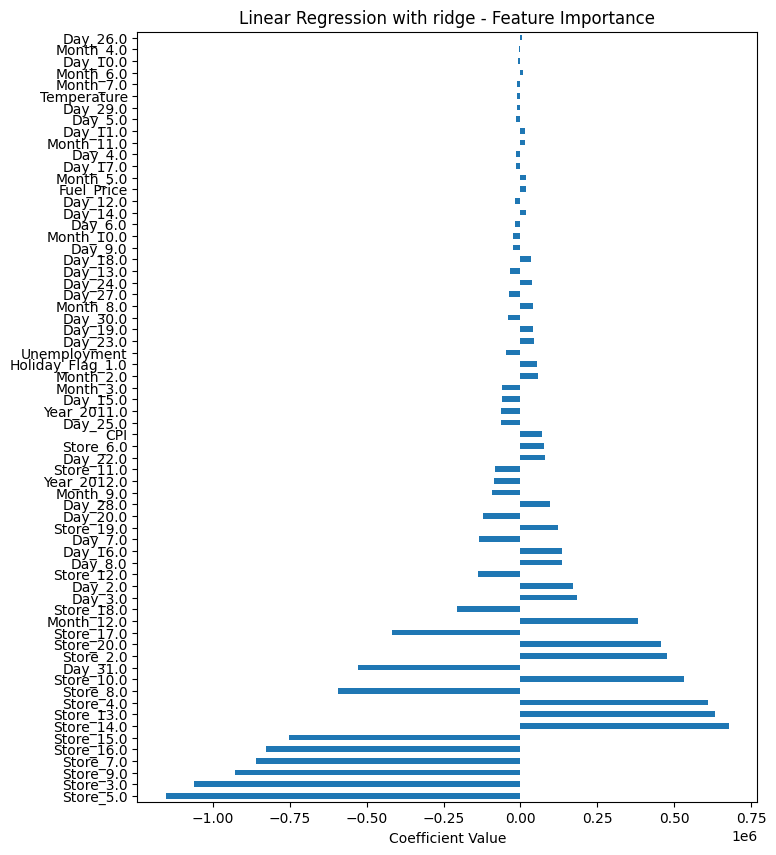

In [33]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   linear_regression_ridge.coef_,
   columns=['Coefficients'], index=col_names
)
# Trier les coefficients par leur valeur absolue en ordre décroissant
coefs['Absolute Coefficient'] = coefs['Coefficients'].abs()
coefs_sorted = coefs.sort_values(by='Absolute Coefficient', ascending=False)

# Affichage du graphique en barres horizontales
coefs_sorted['Coefficients'].plot(kind='barh', figsize=(8, 10))
plt.title('Linear Regression with ridge - Feature Importance')
plt.xlabel('Coefficient Value')

Strore still the most important feature